In [1]:
%pylab inline
from pyspark import SparkContext, SparkConf
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import os
import time
start_time = time.time()
#from VAT import VAT
#from iVAT import iVAT

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
set_selector = 25 # This number selects a UCR time series. 76 is a big one.
cl_est = 10         # Initial guess of number of clusters.
sample_ratio = 0.25

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True

# Data input - assumes this is done externally - not considered part of complexity.
datapath = 'UCR_TS_Archive_2015/'
datadirlist = os.listdir(datapath)
datadirlist.sort()
datadir = datapath+datadirlist[set_selector]+'/'
datafile = [i for i in os.listdir(datadir) if 'TEST' in i]
f = file(datadir+datafile[0])

# Array of time series data. This is a poor way of doing it because it means the series must be 
# strorable in memory before being converted to a RDD.
ts = np.genfromtxt(f, delimiter = ',')
num_series = len(ts)
num_samples = np.ceil(num_series * sample_ratio)
len_series = len(ts[0])
len_series_pow2 = np.power(2,int(np.ceil(np.log2(len_series))))
ts_rows = [i for i in range(num_series)]
for i in range(num_series):
    ts_rows[i] = i, np.append(ts[i,1:], np.zeros(len_series_pow2-len_series))

In [3]:
if not test_run:
    print('There are '+str(num_series)+' series and '+str(len_series)+
          ' samples per series in the \''+datadirlist[set_selector]+'\' dataset.')

    np.where(np.array(os.listdir(datapath)) == 'StarLightCurves')

    plt.plot(ts.T);
    
preprocessing_time = time.time()

In [4]:
# Partitioning component.

# For time series can we assume that the time dimension is reasonable??

# This video covers distributed matrix multiplication
# https://www.youtube.com/watch?v=ap9UOMEMoLw

# Worth noting that correlations are available for MLib but these are only for
# specific types.

# Note that this is always going to be a symmetric output so only need to 
# calculate upper triangle.

# This is actually not the preferred way of distributing data - as we have actually sent this data across all 
# nodes and are just waiting for it to be acted on - in practise this is wasteful.
if optimised:
    ts_distr_rows = sc.parallelize(ts_rows,numSlices=2)
else:
    ts_distr_rows = sc.parallelize(ts_rows)

In [5]:
# CRTICIAL TO PROGRESSING IS FIGURING OUT HOW TO MAP THE ALGORITHMS TO DISTRIBUTED SETTING
# Papers cover interesting ways of mapping common machine learning functions - so maybe there
# are other ways of modifying these for our purposes.

# Seems as the the DIMSUM method optimises the calculation of A*A which could form the 
# dissimilarity matrix?
# OR can this be used to justify the need for using k-shape instead of DTW which would be a 
# much more complex approach...?  PROBLEM needs to be for sparse matrices which doesn't work.

In [6]:
# z-normalise the time series inputs.
znorm_rows = ts_distr_rows.mapValues(lambda row: row - np.mean(row)/np.std(row))

# Transform to Fourier transform.
ft_rows = znorm_rows.mapValues(lambda row: np.fft.fft(row/np.linalg.norm(row)))
# Possibility for long time series where distribution of initial processing is also necessary.
#ft_rows = znorm_rows.mapValues(lambda row: np.fft.fft(row/np.linalg.norm(row))).coalesce(3) 

In [7]:
print 'Input time series have '+str(ft_rows.getNumPartitions())+' partitions.'

# This approach separates the column coordinate from the row,col tuple to allow
# combineByKey to develop each row  of matrix.

# Form cartesian product of all elements to form matrix indices
# This only establishes the upper triangular part.
NCC_row_high = ft_rows.cartesian(ft_rows).filter(lambda (row, col): row[0] >= col[0]).map(
    lambda (row, col): ((row[0], col[0]), 1 - np.max(np.fft.ifft(row[1] * np.conj(col[1])))))

# Alternative ?
# http://stackoverflow.com/questions/38960599/apache-spark-handling-skewed-data

print 'Upper triangle cartesian product has '+str(NCC_row_high.getNumPartitions())+' partitions.'

if not test_run: 
    NCC_row_high_test = NCC_row_high.take(1)
    testtime1 = time.time()
    print testtime1 - preprocessing_time

# This forms the bottom triangle just by copying them the col/row to row/col.    
NCC_row_low = NCC_row_high.filter(lambda ((row, col), dissimilarity): row != col).map(
    lambda ((row, col), dissimilarity): ((col, row), dissimilarity))

if not test_run: 
    NCC_row_low_test = NCC_row_low.take(1)
    testtime2 = time.time()
    print testtime2 - testtime1

NCC_row = NCC_row_high.union(NCC_row_low)   # Forms a full matrix of coordinates.

#glom()  is this better???

def init_array(col_val, num_series = num_series):
    (col, dissimilarity) = col_val
    init_row = np.zeros(num_series)
    init_row[col] = dissimilarity
    return init_row

def build_row(partial_row, next_col_val):
    (col, dissimilarity) = next_col_val
    partial_row[col] = dissimilarity
    return partial_row

print 'Full cartesian product has '+str(NCC_row.getNumPartitions())+' partitions.'

# This combines all rows by the row number and produces an array indexed by column number.
if optimised:
    NCC_rowmat = NCC_row.map(lambda ((row, col), dissimilarity): (row, (col, dissimilarity))
                        ).combineByKey(
                            init_array,build_row,(lambda partial_row1, partial_row2: partial_row1 + partial_row2),
                            numPartitions=1)
else:
    NCC_rowmat = NCC_row.map(lambda ((row, col), dissimilarity): (row, (col, dissimilarity))
                        ).combineByKey(
                            init_array,build_row,(lambda partial_row1, partial_row2: partial_row1 + partial_row2))
    
print 'Combined rows of NCC values have '+str(NCC_rowmat.getNumPartitions())+' partitions.'

if not test_run: 
    NCC_rowmat_test = NCC_rowmat.take(1)
    testtime3 = time.time()
    print testtime3 - testtime2

Input time series have 1 partitions.
Upper triangle cartesian product has 1 partitions.
Full cartesian product has 2 partitions.
Combined rows of NCC values have 1 partitions.


In [8]:
# Start to develop clusiVAT - essentially have a matrix at this point.

# Deteriming cluster seed points - distinguished objects.
# This whole section has almost no paralellisation. Required to calculate immediately.
# How can it be further parallelised?
# Initialise the algorithm by choosing the first instance / row.
m = np.zeros(cl_est)  # index of distinguished points
clus_seed = m[0]
y1 = NCC_rowmat.filter(lambda row: row[0] == clus_seed).collect() # Just collects first row.

dissim_mat_time = time.time()

# Then we have this non-deterministic iteration which requires constant 
# communication back to the RDD looking for the row corresponding to the 
# last distinguished point that is required for the next distinguished point.
# Demonstrate that this part is actually dependent on that parameter selection.
# Entirely dependent on the communications of this algorithm.
# Use the seed row to generate distinguished instance index array, m.
# How could this be just done on each node then sent back and reassembled?
# Justifying a modification is going to require some kind of proof wrt to MST...
for i in range(1,cl_est):
    #y2 = NCC_rowmat.filter(lambda x: x[0] == m[i-1]).cache().collect()
    y2 = NCC_rowmat.filter(lambda x: x[0] == m[i-1]).collect()
    y_min = np.minimum(y1[0][1],y2[0][1])
    m[i] = np.argmax(y_min)
    
m = np.unique(m).astype(int)

disting_inst_time = time.time()

if not test_run: print m

In [9]:
if not test_run: 
    # This defines an array containing the cluster index.
    # Each row should be kept on one node (reasonable?)
    # It needs to have the row ID and the cluster key --> sampling is done based
    # on the cluster key --> map function chooses each cluster and sample randomly.
    # THIS IS NOT A NECESSARY STEP - JUST REQUIRED TO CHECK COUNT OF INPUT DATA.
    #proto_clust = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), (ind, row)))
    proto_clust = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), ind))

    # Count number of instances in each protocluster.
    proto_clust_cnt = proto_clust.combineByKey((lambda row: 1),(lambda comb,row: comb+1),(lambda comb1, comb2: comb1+comb2))
    
    print proto_clust_cnt.collect()
    #print proto_clust.take(5)
    #print proto_clust.collect()

In [10]:
if sample_ratio != 1.0: 
    # Chooses a random selection of points for each distinguished object.
    # COLLECT: Need to have a key-value pairs that are capable of returning a reduced dissimilarity matrix.
    # - Requires 
    # So each
    fractions = {i: sample_ratio for i in range(len(m))}

    # This sampling just selects each item with certain probability.
    # Fails to meet the criterium of selecting a proportional amount.
    # May need to take into account the partitioning here to ensure that it is done correctly...
    # This will approach the right value as the set size increases??
    NCC_rowmat_sample = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), (ind, row))
                                      ).sampleByKey(False,fractions)
    
    # This test proved that every time this is evaluated it produces a different sample (der)
    #test1 = NCC_rowmat_sample.collect()
    #test2 = NCC_rowmat_sample.collect()

    # THIS IS NOT A NECESSARY STEP BUT NEEDED TO VERIFY SAMPLE FRACTION.
    if not test_run: 
        sample_cnt = NCC_rowmat_sample.combineByKey(
            (lambda row: 1),(lambda comb,row: comb+1),(lambda comb1, comb2: comb1+comb2))
        print sample_cnt.collect()
else:
    NCC_rowmat_sample = NCC_rowmat.map(lambda (ind, row): (np.argmin(row[m]), (ind, row)))
    if not test_run: print NCC_rowmat_sample.take(5)


In [11]:
# http://www.bigsynapse.com/sampling-large-datasets-using-spark
# https://spark-summit.org/2014/a-deeper-understanding-of-spark-internals/
# Alternative approaches?

# This will minimise the amount of communication by only sending back sampled row indexes.
# THIS DOESN'T WORK BECAUSE IT RESAMPLES THE DATA
# sample_ind = NCC_rowmat_sample.map(lambda (clus, row): row[0]).collect()

sample_time = time.time()

In [12]:
# This will minimise comms by only sending back the dissimilarity data that is required for the reduced matrix.
# Is sorting required??
# THIS IS THE DISSIMILARITY MATRIX
# sample_ind.sort()

NCC_matrix = NCC_rowmat_sample.map(lambda (clus, row): (row[0],row[1])).collect()

NCC_matrix.sort(key = lambda tup: tup[0])

sample_ind = np.array([i[0] for i in NCC_matrix])

if not test_run: print NCC_matrix

In [13]:
NCC_mat_final = np.vstack(tuple(i[1][sample_ind] for i in NCC_matrix))

if not test_run: print NCC_mat_final

In [14]:
end_time = time.time()

pre_time = preprocessing_time - start_time
build_dissim_mat = dissim_mat_time - preprocessing_time
id_dist_inst = disting_inst_time - dissim_mat_time
map_rows_to_seed = sample_time - disting_inst_time
produce_matrix = end_time - sample_time

runtime = end_time - start_time
print("Pre-processing time = %s seconds ---" % pre_time)
print("Unordered dissimilarity matrix development = %s seconds ---" % build_dissim_mat)
print("Find distinguishing instances = %s seconds ---" % id_dist_inst)
print("Map to prototype cluster = %s seconds ---" % map_rows_to_seed)
print("Produce sampled matrix =  %s seconds ---" % produce_matrix)
print("Total runtime =  %s seconds ---" % runtime)

Pre-processing time = 0.487277984619 seconds ---
Unordered dissimilarity matrix development = 206.932726145 seconds ---
Find distinguishing instances = 3.03502488136 seconds ---
Map to prototype cluster = 0.074716091156 seconds ---
Produce sampled matrix =  0.793802022934 seconds ---
Total runtime =  211.323547125 seconds ---


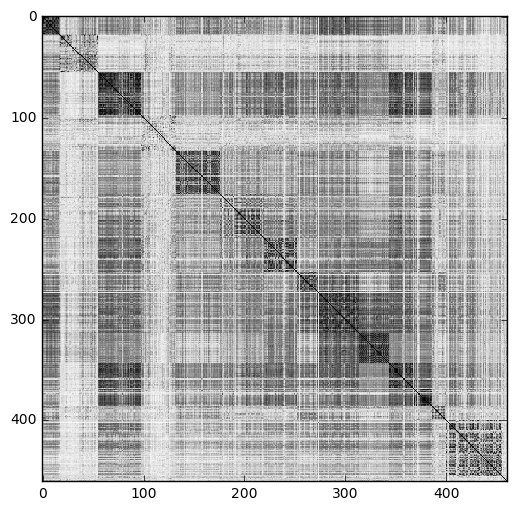

In [15]:
figure(figsize=(6,6))
plt.imshow(NCC_mat_final,cmap='Greys_r',interpolation='none');

In [16]:
numpy.savetxt('test_matrix_quarter.csv', NCC_mat_final, delimiter=',')
#NCC_mat_final

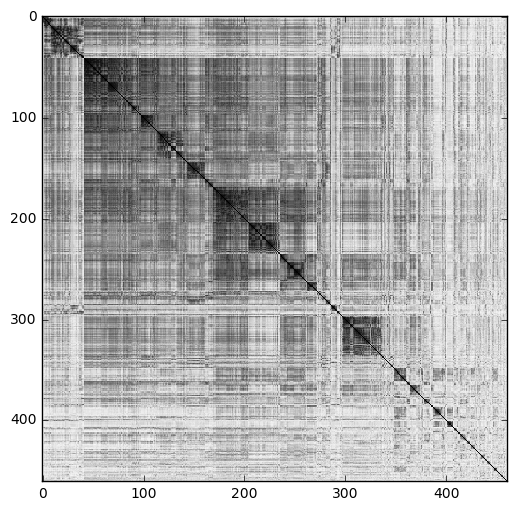

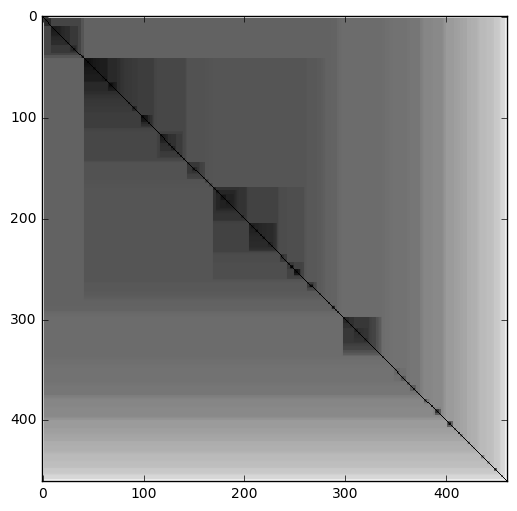

In [17]:
VAT_calc = True

if VAT_calc:
    from VAT import VAT
    from iVAT import iVAT
    
    #R_VAT, I_VAT, C = VAT(NCC_mat_final)

    #figure(figsize=(6,6))
    #plt.imshow(R_VAT,cmap='Greys_r',interpolation='none');

    D_iVAT, D_VAT, I_VAT, C, d = iVAT(NCC_mat_final)

    figure(figsize=(6,6))
    plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');
    
    figure(figsize=(6,6))
    plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');

In [18]:
eendtime = time.time()

totalruntime = eendtime - start_time
print("Total runtime =  %s seconds ---" % totalruntime)

#numpy.savetxt('VAT_matrix.csv', D_VAT, delimiter=',')

Total runtime =  214.26722908 seconds ---
